In [37]:
# coding: utf8

In [38]:
import math
import pandas as pd
import numpy  as np
import seaborn as sb
import matplotlib.pyplot as plt

In [39]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split

In [40]:
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
sb.set(style="white", color_codes=True)

## Constantes

In [41]:
NON_FEATURES = ["Pclass", "Cabin", "Name", "Ticket", "Embarked", "Cabin.U"]
SEED_STATE = 1
KFOLDS_NUM = 10

## Functions

In [42]:
def binary(df, column, values=["1", "0"]):
    """
    params
    ----------

    return
    ----------
    """
    for value in values:
            df["%s.%s"%(column,value)] = map(lambda y: 1 if y == value else 0, df[column])
    return df

In [43]:
def dataCleaning(df, inPlace=True, toDrop=NON_FEATURES):
    """
        
    """
    #median_age = df["Age"].median()
    #df["Age"].fillna(median_age, inplace=True)
    df["Cabin"].fillna("unknow", inplace=inPlace)
    df["Cabin"] = map(lambda y: y[0].upper(), df["Cabin"])
    
    df["Embarked"].fillna("C", inplace=inPlace)
    
    df["Sex"] = df["Sex"].map({'female': 0, 'male': 1}).astype(int)
    
    bridges = sorted(df["Cabin"].unique())
    
    df = binary(df, column="Embarked", values=['C', 'Q', 'S'])
    df = binary(df, column="Pclass", values=['1', '2', '3'])
    df = binary(df, column="Cabin", values=bridges)
    
    return df.drop(toDrop, axis=1)

In [44]:
def rmse(actual, pred):
    return np.sqrt(( actual - pred )**2).sum() / len(actual)

## Dataset

In [45]:
train = pd.read_csv("data/train.csv").drop(["Survived"], axis=1)
test = pd.read_csv("data/test.csv")

In [46]:
train = dataCleaning(train)
test = dataCleaning(test)

In [47]:
print "Nombre de N/A %s / %s"%(train.isnull().sum()[2],len(train))
print "Nombre de N/A %s / %s"%(test.isnull().sum()[2],len(test))

Nombre de N/A 177 / 891
Nombre de N/A 86 / 418


In [48]:
train.tail(4)

,PassengerId,Sex,Age,SibSp,Parch,Fare,Embarked.C,Embarked.Q,Embarked.S,Pclass.1,Pclass.2,Pclass.3,Cabin.A,Cabin.B,Cabin.C,Cabin.D,Cabin.E,Cabin.F,Cabin.G,Cabin.T
887,888,0,19,0,0,30.00,0,0,1,0,0,0,0,1,0,0,0,0,0,0
888,889,0,NaN,1,2,23.45,0,0,1,0,0,0,0,0,0,0,0,0,0,0
889,890,1,26,0,0,30.00,1,0,0,0,0,0,0,0,1,0,0,0,0,0
890,891,1,32,0,0,7.75,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
test.tail(4)

,PassengerId,Sex,Age,SibSp,Parch,Fare,Embarked.C,Embarked.Q,Embarked.S,Pclass.1,Pclass.2,Pclass.3,Cabin.A,Cabin.B,Cabin.C,Cabin.D,Cabin.E,Cabin.F,Cabin.G
414,1306,0,39.0,0,0,108.9000,1,0,0,0,0,0,0,0,1,0,0,0,0
415,1307,1,38.5,0,0,7.2500,0,0,1,0,0,0,0,0,0,0,0,0,0
416,1308,1,NaN,0,0,8.0500,0,0,1,0,0,0,0,0,0,0,0,0,0
417,1309,1,NaN,1,1,22.3583,1,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
train.dropna(inplace=True)
test.dropna(inplace=True)
print "Nombre de N/A %s / %s"%(train.isnull().sum()[2],len(train))
print "Nombre de N/A %s / %s"%(test.isnull().sum()[2],len(test))

Nombre de N/A 0 / 714
Nombre de N/A 0 / 331


In [51]:
titanic = pd.concat([train, test])

In [52]:
len(titanic)

1045

In [53]:
dataset = titanic.iloc[np.random.permutation(len(titanic))].drop("Cabin.T", axis=1)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=1)

In [92]:
reg_tree = DecisionTreeRegressor(min_samples_split=25)
reg_tree.fit(train_data.drop("Age", axis=1),train_data["Age"])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=25,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [93]:
reg_tree.score(test_data.drop("Age", axis=1), test_data["Age"])

0.11220906741643077

In [94]:
rmse(train_data["Age"], reg_tree.predict(train_data.drop("Age", axis=1)))

7.464723845084419

In [95]:
rmse(test_data["Age"], reg_tree.predict(test_data.drop("Age", axis=1)))

10.537472803612344

In [58]:
result_data = pd.DataFrame()
result_data["Age"] = test_data["Age"]
result_data["Prediction"] = reg_tree.predict(test_data.drop("Age", axis=1))

In [97]:
result_data[["Age", "Prediction"]].head(5)

,Age,Prediction
810,26.0,25.076923
130,33.0,32.500000
35,18.5,26.928571
479,2.0,18.000000
342,28.0,29.590909


## Cross validation

In [120]:
cv_titanic = titanic.dropna()
iterration = 0
cv_iterration = 0

verbose = False
cross_train_error = []
cross_valid_error = []

In [121]:
cv_set = StratifiedKFold( cv_titanic.index.tolist(), KFOLDS_NUM, random_state=SEED_STATE, shuffle=True)

In [172]:
for leaf_size in xrange(1, 70, 4):
    
    if(True): print "========= Running Cross Validation on the size: ",leaf_size
    cv_train_error = []
    cv_valid_error = []
    
    cv_iterration = train_score = valid_score = 0
    iterration = iterration + 1
    
    for ct, cv in cv_set:
        cv_iterration = cv_iterration + 1
        
        if(verbose): print "::::::::: Running Cross Validation," + \
            "iteration n°%i, use leaf size: %i :::::::::"%(cv_iterration, leaf_size)
        
        cross_train_set = cv_titanic[cv_titanic.index.isin(ct)]
        cross_valid_set = cv_titanic[cv_titanic.index.isin(cv)]
        
        cv_tree = DecisionTreeRegressor(min_samples_split=11, random_state=SEED_STATE, min_samples_leaf=leaf_size)
        cv_tree.fit(cross_train_set.drop("Age", axis=1), cross_train_set["Age"])
        
        train_error = rmse(
            cross_train_set["Age"],
            cv_tree.predict(cross_train_set.drop("Age", axis=1))
        )
        
        valid_error = rmse(
            cross_valid_set["Age"],
            cv_tree.predict(cross_valid_set.drop("Age", axis=1))
        )
        
        cv_train_error.append(train_error)
        cv_valid_error.append(valid_error)
        
        
        
        if(verbose): print "::::::::: train error = %s "%train_error + \
            " validation error = %s :::::::::"%valid_error
    
    cross_train_error.append(np.mean(cv_train_error))
    cross_valid_error.append(np.mean(cv_valid_error))
    
    if(verbose): print "::::::::: train error = %s "%train_error + \
            " validation error = %s :::::::::"%valid_error
    
    #print np.mean(cv_train_error)
    #print np.mean(cv_valid_error)
        
        
    

========= Running Cross Validation on the size:  1
========= Running Cross Validation on the size:  5
========= Running Cross Validation on the size:  9
========= Running Cross Validation on the size:  13
========= Running Cross Validation on the size:  17
========= Running Cross Validation on the size:  21
========= Running Cross Validation on the size:  25
========= Running Cross Validation on the size:  29
========= Running Cross Validation on the size:  33
========= Running Cross Validation on the size:  37
========= Running Cross Validation on the size:  41
========= Running Cross Validation on the size:  45
========= Running Cross Validation on the size:  49
========= Running Cross Validation on the size:  53
========= Running Cross Validation on the size:  57
========= Running Cross Validation on the size:  61
========= Running Cross Validation on the size:  65
========= Running Cross Validation on the size:  69


In [173]:
#cross_valid_error

In [174]:
cv_error_df = pd.DataFrame({'cross_train_error': cross_train_error , 'cross_valid_error': cross_valid_error})

In [175]:
np.argmin(cross_valid_error)

4

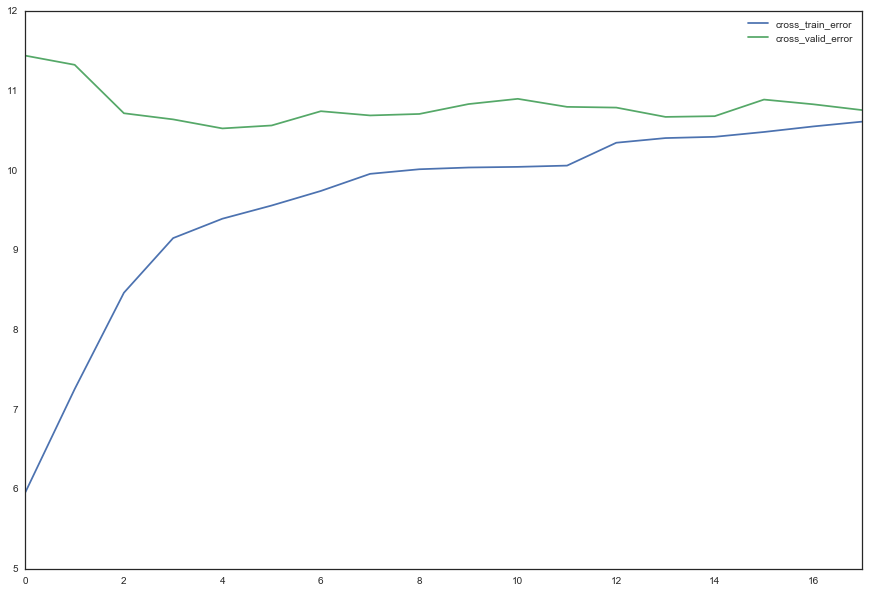

In [176]:
cv_error_df.plot(figsize=(15, 10))
cross_train_error = []
cross_valid_error = []